# RAIDIUM MEDICAL ORGANS CLUSTERING PROJECT

## Imports

In [ ]:
!lscpu

Architecture:             x86_64
  CPU op-mode(s):         32-bit, 64-bit
  Address sizes:          46 bits physical, 48 bits virtual
  Byte Order:             Little Endian
CPU(s):                   4
  On-line CPU(s) list:    0-3
Vendor ID:                GenuineIntel
  Model name:             Intel(R) Xeon(R) CPU @ 2.00GHz
    CPU family:           6
    Model:                85
    Thread(s) per core:   2
    Core(s) per socket:   2
    Socket(s):            1
    Stepping:             3
    BogoMIPS:             4000.36
    Flags:                fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge m
                          ca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht sysc
                          all nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xt
                          opology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq
                           ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt
                           aes xsave avx f16c rdrand hypervisor 

In [2]:
!pip3 install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu126
!pip -q install iterative-stratification

In [3]:
import tensorflow as tf  
# Check if GPU is available
print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))

# Ensure TensorFlow uses GPU
tf.config.experimental.set_memory_growth(tf.config.experimental.list_physical_devices('GPU')[0], True)

Num GPUs Available: 1


## Fetching dataset

In [4]:
!wget https://challengedata.ens.fr/media/public/label_Hnl61pT.csv -O y_train.csv

--2025-03-07 15:20:55--  https://challengedata.ens.fr/media/public/label_Hnl61pT.csv
Resolving challengedata.ens.fr (challengedata.ens.fr)... 129.199.99.148
Connecting to challengedata.ens.fr (challengedata.ens.fr)|129.199.99.148|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 267819968 (255M) [text/csv]
Saving to: ‘y_train.csv’

y_train.csv         100%[===================>] 255.41M  99.9MB/s    in 2.6s    

2025-03-07 15:20:58 (99.9 MB/s) - ‘y_train.csv’ saved [267819968/267819968]



In [5]:
# downloading the images

!wget https://challengedata.ens.fr/media/public/train-images.zip
!wget  https://challengedata.ens.fr/media/public/test-images.zip
!wget https://challengedata.ens.fr/media/public/annotated_labels.json

--2025-03-07 15:20:58--  https://challengedata.ens.fr/media/public/train-images.zip
Resolving challengedata.ens.fr (challengedata.ens.fr)... 129.199.99.148
Connecting to challengedata.ens.fr (challengedata.ens.fr)|129.199.99.148|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 52391647 (50M) [application/zip]
Saving to: ‘train-images.zip.1’

train-images.zip.1  100%[===================>]  49.96M  89.9MB/s    in 0.6s    

2025-03-07 15:20:59 (89.9 MB/s) - ‘train-images.zip.1’ saved [52391647/52391647]

--2025-03-07 15:20:59--  https://challengedata.ens.fr/media/public/test-images.zip
Resolving challengedata.ens.fr (challengedata.ens.fr)... 129.199.99.148
Connecting to challengedata.ens.fr (challengedata.ens.fr)|129.199.99.148|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12803342 (12M) [application/zip]
Saving to: ‘test-images.zip.1’

test-images.zip.1   100%[===================>]  12.21M  60.7MB/s    in 0.2s    

2025-03-07 15:20:59 

In [6]:
# Unzip images

!unzip -q -n train-images.zip
!unzip -q -n test-images.zip

In [7]:
import pandas as pd 

# Load the train labels
# Note the transpose!
labels_train = pd.read_csv("y_train.csv", index_col=0).T

In [8]:
# load annotated_labels.json
import json 

with open("annotated_labels.json", "r") as f:
    annotated_labels = json.load(f)

In [9]:
# Here is a function to load the data
def load_dataset(dataset_dir):
    dataset_list = []
    # Note: It's very important to load the images in the correct numerical order!
    for image_file in list(sorted(Path(dataset_dir).glob("*.png"), key=lambda filename: int(filename.name.rstrip(".png")))):
        dataset_list.append(cv2.imread(str(image_file), cv2.IMREAD_GRAYSCALE))
    return np.stack(dataset_list, axis=0)

In [10]:
!pip install cv

In [11]:
from pathlib import Path
import cv2
import numpy as np

# Load the train and test sets
# If you've put the shortcut directly in your drive, this should work out of the box
# Else, edit the path
data_dir = Path("./")
data_train = load_dataset(data_dir / "train-images")
data_test = load_dataset(data_dir / "test-images")

## Visualize dataset

In [12]:
labels_train

,Pixel 0,Pixel 1,Pixel 2,Pixel 3,Pixel 4,Pixel 5,Pixel 6,Pixel 7,Pixel 8,Pixel 9,...,Pixel 65526,Pixel 65527,Pixel 65528,Pixel 65529,Pixel 65530,Pixel 65531,Pixel 65532,Pixel 65533,Pixel 65534,Pixel 65535
0.png,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1.png,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2.png,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3.png,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4.png,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995.png,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1996.png,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1997.png,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1998.png,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
# Each image in annotated_labels contains 27 clusters,
# only some of these were actually annotated pixel by pixel in labels_train
# hence most cluster ids are not represented on most images and replaced by 0s..

df_annotated_labels = pd.DataFrame(annotated_labels).fillna(-1)
df_annotated_labels.index = [f"{i}.png" for i in range(len(annotated_labels))]  # Add .png extension

df_annotated_labels

# -1 means empty value... basically 1200 images do not have clusters?

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
0.png,2.0,4.0,8.0,10.0,11.0,12.0,13.0,14.0,15.0,18.0,...,32.0,36.0,44.0,46.0,47.0,49.0,50.0,52.0,53.0,54.0
1.png,4.0,6.0,10.0,11.0,12.0,13.0,15.0,17.0,19.0,21.0,...,37.0,42.0,45.0,46.0,47.0,48.0,49.0,51.0,53.0,54.0
2.png,2.0,3.0,6.0,7.0,8.0,9.0,11.0,12.0,16.0,18.0,...,33.0,34.0,36.0,38.0,39.0,42.0,44.0,49.0,50.0,54.0
3.png,1.0,6.0,7.0,12.0,16.0,17.0,20.0,21.0,23.0,24.0,...,36.0,38.0,41.0,43.0,47.0,48.0,51.0,52.0,53.0,54.0
4.png,4.0,5.0,9.0,11.0,12.0,13.0,15.0,17.0,20.0,22.0,...,39.0,40.0,41.0,43.0,44.0,45.0,48.0,50.0,52.0,54.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995.png,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1996.png,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1997.png,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1998.png,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [14]:
# The train data is a numpy array of 1000 images of 512*512
print(f"X_train shape: {data_train.shape}")
# The train label is a dataframe of 1000 rows with 262144 (=512x512) columns
print(f"Y_train shape: {labels_train.shape}")

X_train shape: (2000, 256, 256)
Y_train shape: (2000, 65536)


In [15]:
# Let's display some data
# Here is a function to display side by side a slide and a segmented mask
def plot_slice_seg(slice_image, seg):
    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(slice_image, cmap="gray")
    axes[1].imshow(slice_image, cmap="gray")
    seg_masked = np.ma.masked_where(seg.reshape((256,256)) == 0, (seg.reshape((256,256))))
    axes[1].imshow(seg_masked, cmap="tab20")
    plt.axis("off")

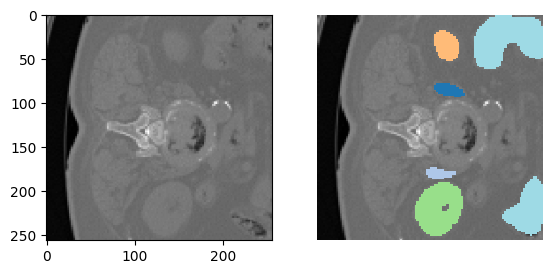

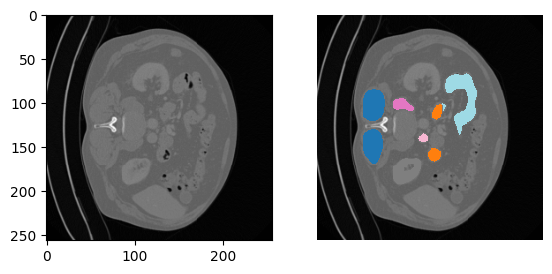

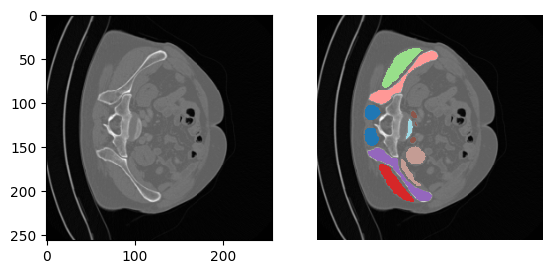

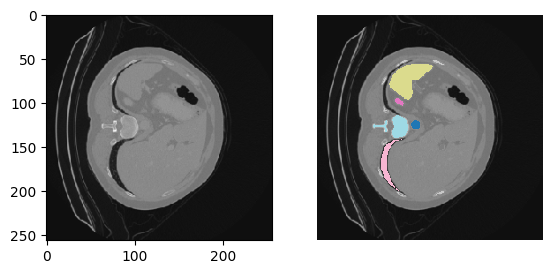

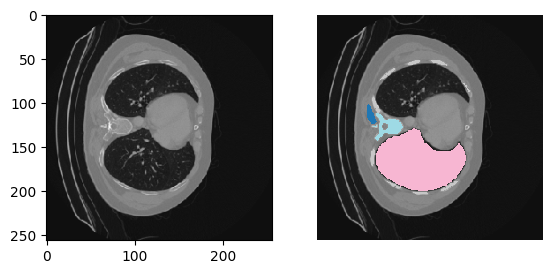

In [16]:
# Let's try it on some slides and their segmentation masks
# Note: we have to reshape the rows of the dataframe into a 256*256 matrix
import matplotlib.pyplot as plt

for i in range(10, 15):
  plot_slice_seg(data_train[i], labels_train.iloc[i].values.reshape((256,256)))

## Dataset analysis

In [17]:
# Boolean mask for rows that contain only zeros
zero_rows = labels_train.eq(0).all(axis=1)

# Count rows that contain only zeros (unannotated images)
unannotated_labels_train = zero_rows.sum()

print(f"Number of unannotated images in labels_train: {unannotated_labels_train}")

Number of unannotated images in labels_train: 1241


In [18]:
# Boolean mask for rows that contain at least one nonzero pixel
annotated_rows = labels_train.ne(0).any(axis=1)

# Filter only the 800 images with labeled structures
labels_train_annotated = labels_train[annotated_rows]

# Print the number of remaining images
print(f"Number of annotated images in labels_train: {labels_train_annotated.shape[0]}")

Number of annotated images in labels_train: 759


In [19]:
# Count the number of images with empty lists (unannotated)
unannotated_json = sum(len(labels) == 0 for labels in annotated_labels)

print(f"Number of unannotated images in annotated_labels.json: {unannotated_json}")

Number of unannotated images in annotated_labels.json: 1200


In [20]:
# Count the number of images with empty lists (unannotated)
annotated_json = sum(len(labels) > 0 for labels in annotated_labels)

print(f"Number of annotated images in annotated_labels.json: {annotated_json}")

Number of annotated images in annotated_labels.json: 800


In [21]:
# Labels are 0 for background and 1 to 54 for all organs
print(sorted(labels_train.stack().unique()))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54]


In [22]:
# Example

image_id = 39
labels_for_image = annotated_labels[image_id]

print(f"{len(labels_for_image)} annotated labels for image {image_id}.png: {labels_for_image}")

27 annotated labels for image 39.png: [1, 2, 4, 7, 10, 11, 12, 15, 16, 17, 21, 24, 26, 28, 31, 32, 39, 40, 41, 43, 44, 47, 48, 49, 50, 52, 54]


In [23]:
# less labels actually present in labels_train... others replaced by 0s...
labels_train.loc["39.png"].value_counts()

39.png
0     64361
54      681
4       233
43      226
11       35
Name: count, dtype: int64

In [24]:
print(f"Number of annotated images in labels_train: {labels_train_annotated.shape[0]}")

# Get the indices (or filenames) of annotated images.
# (Assuming that the index of labels_df is the image filename, e.g. "0.png", "1.png", etc.)
annotated_filenames = labels_train_annotated.index.tolist()
print("Annotated filenames (first 10):", annotated_filenames[:10])

Number of annotated images in labels_train: 759
Annotated filenames (first 10): ['0.png', '1.png', '2.png', '3.png', '4.png', '6.png', '7.png', '8.png', '9.png', '10.png']


1        926
2        673
3     115092
4     208579
5     201305
6     283963
7       4723
8       4422
9     247582
10     19671
11     17542
12    320273
13      7937
14      6131
15      7501
16     65158
17     55008
18     63491
19     68319
20     11931
21     14037
22    330252
23     90404
24     76409
25      1977
26      1859
27      4612
28      5045
29      9206
30      6423
31     87612
32     86498
33     28015
34     47374
35     55493
36    550923
37    781124
38    925175
39     20693
40      5564
41     36685
42     53261
43     50937
44     76503
45     17677
46     14275
47    315423
48     72506
49    111266
50     13885
51     28022
52     51741
53    110911
54    159006
Name: count, dtype: int64


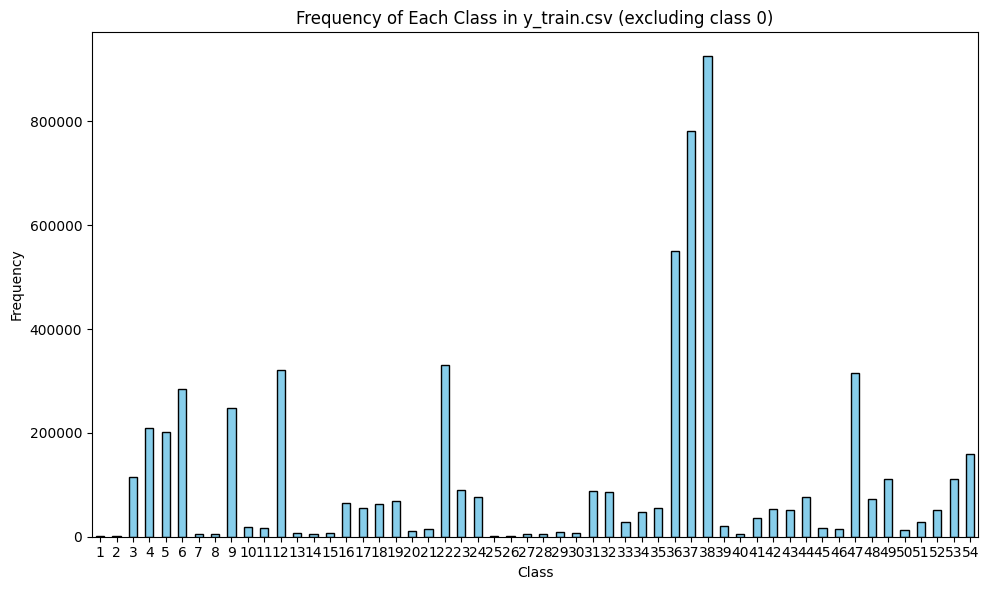

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming labels_train is already loaded, for example:
# labels_train = pd.read_csv("y_train.csv", index_col=0).T

# Flatten all values and compute frequency counts
all_values = labels_train.values.flatten()
frequency = pd.Series(all_values).value_counts().sort_index()

# Exclude class 0
if 0 in frequency.index:
    frequency = frequency.drop(0)

print(frequency)

# Create a bar chart
plt.figure(figsize=(10, 6))
frequency.plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("Frequency of Each Class in y_train.csv (excluding class 0)")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [26]:
import pandas as pd

# Read the entire CSV and select only 10 random rows
train_df = pd.read_csv("y_train.csv", index_col=0).sample(n=30, axis=1, random_state=42)

# Save the selected subset to a new CSV file
train_df.to_csv("y_train_sampled.csv", index=True)

print("Saved y_train_sampled.csv with shape:", train_df.shape)

Saved y_train_sampled.csv with shape: (65536, 30)


In [30]:
!git clone https://github.com/facebookresearch/segment-anything-2

fatal: destination path 'segment-anything-2' already exists and is not an empty directory.


In [31]:
!cd segment-anything-2 && ls && pip install -e .

assets		    demo		 notebooks	   sav_dataset
backend.Dockerfile  docker-compose.yaml  pyproject.toml    setup.py
checkpoints	    INSTALL.md		 README.md	   tools
CODE_OF_CONDUCT.md  LICENSE		 RELEASE_NOTES.md  training
CONTRIBUTING.md     LICENSE_cctorch	 sam2
data		    MANIFEST.in		 SAM_2.egg-info
Obtaining file:///kaggle/working/segment-anything-2
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for SAM-2 (pyproject.toml) ... done
  Created wheel for SAM-2: filename=sam_2-1.0-0.editable-cp310-cp310-linux_x86_64.whl size=13817 sha256=ef516c7f9e091c088df93b1b141a54b06807e525f45a6ca9a3a6b4ca77085884
  Stored in directory: /tmp/pip-ephem-wheel-cache-h3xt7m4w/wheels/1b/30/72/94667a625e111d514f83ac75152c8957c764a2c56d72e883a6
Successfully built SAM-2
  Attempting uninstall: SAM-2
    Found existing installation: SAM

In [50]:
os.chdir("/kaggle/working/")
!wget -O sam2_hiera_small.pt "https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_small.pt"

--2025-03-07 15:34:35--  https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_small.pt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.227.219.59, 13.227.219.10, 13.227.219.33, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.227.219.59|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 184309650 (176M) [application/vnd.snesdev-page-table]
Saving to: ‘sam2_hiera_small.pt’

sam2_hiera_small.pt 100%[===================>] 175.77M   223MB/s    in 0.8s    

2025-03-07 15:34:36 (223 MB/s) - ‘sam2_hiera_small.pt’ saved [184309650/184309650]



In [33]:
!mkdir data && mv train-images test-images y_train.csv data

mkdir: cannot create directory ‘data’: File exists


In [34]:
!ls

annotated_labels.json	 segment-anything-2  train-images
annotated_labels.json.1  tb_logs	     train-images.zip
data			 test-images	     train-images.zip.1
models			 test-images.zip     y_train.csv
sam2_hiera_tiny.pt	 test-images.zip.1   y_train_sampled.csv


In [35]:
import os
os.chdir("/kaggle/working/")

import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# ----------------------------
# Step 1. Configuration and Paths
# ----------------------------
# Define the base data folder (adjust as needed)
DATA_FOLDER = "data"  # No trailing slash

# Define paths for original train images and the CSV file containing masks
TRAIN_IMAGES_DIR = os.path.join(DATA_FOLDER, "train-images")
Y_TRAIN_CSV = os.path.join(DATA_FOLDER, "y_train.csv")

# Define the output folder for the masks and for the new train CSV
MASKS_DIR = os.path.join(DATA_FOLDER, "masks")
os.makedirs(MASKS_DIR, exist_ok=True)

# ----------------------------
# Step 2. Load and Filter y_train.csv
# ----------------------------
# Load the CSV; note that the CSV is transposed so that each row corresponds to an image
df = pd.read_csv(Y_TRAIN_CSV, index_col=0).T
print("Original y_train.csv shape:", df.shape)

# Filter out rows that contain only zeros (no annotated mask)
mask = ~(df.values == 0).all(axis=-1)
df_filtered = df[mask]
print("Filtered train data shape:", df_filtered.shape)

# ----------------------------
# Step 3. Reshape and Save Masks as Images
# ----------------------------
# For each row in the filtered DataFrame, reshape the flattened mask into 256x256 and save as an image
for file_name in df_filtered.index:
    # Get the flattened mask as a numpy array (assumed type convertible to uint8)
    mask_flat = df_filtered.loc[file_name].values.astype(np.uint8)
    # Reshape into 256x256 (since 256*256 = 65536)
    mask_img = mask_flat.reshape(256, 256)
    # Save the mask image into the MASKS_DIR with the same filename (e.g., "23.png")
    out_path = os.path.join(MASKS_DIR, file_name)
    cv2.imwrite(out_path, mask_img)
print("Saved masks to:", MASKS_DIR)

# Step 4. Create a New CSV File Mapping Filtered Images to Masks

# Use the filtered train_df index (which contains only images for which a mask was saved)
filtered_filenames = list(train_df.index)  # e.g. ['23.png', '45.png', ..., 'xxx.png']

# (Optionally, sort them numerically using a helper function)
import re
def numeric_key(filename):
    number_str = re.sub(r'\D', '', filename)
    return int(number_str) if number_str else float('inf')

filtered_filenames = sorted(filtered_filenames, key=numeric_key)

# Create a DataFrame with two columns: ImageId and MaskId.
# We assume that the mask files in the masks folder have the same filenames as in the filtered list.
train_csv_df = pd.DataFrame({
    "ImageId": filtered_filenames,
    "MaskId": filtered_filenames  # because masks are saved with the same names in data/masks
})

# Save this DataFrame as "train.csv" in your DATA_FOLDER.
TRAIN_CSV_PATH = os.path.join(DATA_FOLDER, "train.csv")
train_csv_df.to_csv(TRAIN_CSV_PATH, index=False)
print("Created new CSV mapping images to masks at:", TRAIN_CSV_PATH)

# ----------------------------
# Step 5. (Optional) Split the Data into Train and Test Sets
# ----------------------------
# If you wish to split your dataset into train and test sets for fine-tuning SAM2,
# you can use train_test_split. For example:
train_split, test_split = train_test_split(train_csv_df, test_size=0.2, random_state=42)
train_split.to_csv(os.path.join(DATA_FOLDER, "train_split.csv"), index=False)
test_split.to_csv(os.path.join(DATA_FOLDER, "test_split.csv"), index=False)
print("Saved train_split.csv and test_split.csv in", DATA_FOLDER)

# ----------------------------
# Summary:
# Your data is now restructured as follows:
#   - Train images are in:    DATA_FOLDER/train-images/
#   - Masks are now saved in:  DATA_FOLDER/masks/
#   - A new CSV file mapping images to masks is saved as: DATA_FOLDER/train.csv
#   - (Optionally) train/test split CSV files are also created.
#
# You can now use these files with the SAM2 fine-tuning tutorial.

Original y_train.csv shape: (2000, 65536)
Filtered train data shape: (759, 65536)
Saved masks to: data/masks
Created new CSV mapping images to masks at: data/train.csv
Saved train_split.csv and test_split.csv in data


In [54]:
import matplotlib.colors as mcolors

def read_batch(data, visualize_data=False):
    # Select a random entry
    ent = data[np.random.randint(len(data))]

    image_path = ent["image"]
    annotation_path = ent["annotation"]

    Img = cv2.imread(image_path)

    if Img is None:
        print(f"Error: Could not read image from {image_path}")
        return None, None, None, 0

    # Convert BGR to RGB
    Img = Img[..., ::-1]
    
    # Get full paths
    ann_map = cv2.imread(annotation_path, cv2.IMREAD_GRAYSCALE)
    
    if Img is None or ann_map is None:
       print(f"Error: Could not read image or mask from path {ent['image']} or {ent['annotation']}")
       return None, None, None, 0
    
    # Resize image and mask
    r = np.min([1024 / Img.shape[1], 1024 / Img.shape[0]])  # Scaling factor
    Img = cv2.resize(Img, (int(Img.shape[1] * r), int(Img.shape[0] * r)))
    ann_map = cv2.resize(ann_map, (int(ann_map.shape[1] * r), int(ann_map.shape[0] * r)), interpolation=cv2.INTER_NEAREST)
    
    ### Continuation of read_batch() ###
    
    # Initialize a single binary mask
    binary_mask = np.zeros_like(ann_map, dtype=np.uint8)
    points = []
    
    # Get binary masks and combine them into a single mask
    inds = np.unique(ann_map)[1:]  # Skip the background (index 0)
    for ind in inds:
       mask = (ann_map == ind).astype(np.uint8)  # Create binary mask for each unique index
       binary_mask = np.maximum(binary_mask, mask)  # Combine with the existing binary mask
    
    # Erode the combined binary mask to avoid boundary points
    eroded_mask = cv2.erode(binary_mask, np.ones((5, 5), np.uint8), iterations=1)

    # Get all coordinates inside the eroded mask and choose a random point
    coords = np.argwhere(eroded_mask > 0)
    if len(coords) > 0:
       for _ in inds:  # Select as many points as there are unique labels
           yx = np.array(coords[np.random.randint(len(coords))])
           points.append([yx[1], yx[0]])

    points = np.array(points)
    
    ### Continuation of read_batch() ###
    
    if visualize_data:
        # Plotting the images and points
        plt.figure(figsize=(15, 5))
    
        # Original Image
        plt.subplot(1, 3, 1)
        plt.title('Original Image')
        plt.imshow(Img)
        plt.axis('off')

        # Segmentation Mask (binary_mask)
        plt.subplot(1, 3, 2)
        plt.title('Binarized Mask')
        plt.imshow(binary_mask, cmap='gray')
        plt.axis('off')
    
        # Mask with Points in Different Colors
        plt.subplot(1, 3, 3)
        plt.title('Binarized Mask with Points')
        plt.imshow(binary_mask, cmap='gray')
    
        # Plot points in different colors
        colors = list(mcolors.TABLEAU_COLORS.values())
        for i, point in enumerate(points):
            plt.scatter(point[0], point[1], c=colors[i % len(colors)], s=100, label=f'Point {i+1}')  # Corrected to plot y, x order
    
        # plt.legend()
        plt.axis('off')
    
        plt.tight_layout()
        plt.show()

    binary_mask = np.expand_dims(binary_mask, axis=-1)  # Now shape is (1024, 1024, 1)
    binary_mask = binary_mask.transpose((2, 0, 1))
    points = np.expand_dims(points, axis=1)
    
    # Return the image, binarized mask, points, and number of masks
    return Img, binary_mask, points, len(inds)

In [37]:
images_dir = "data/train-images"
masks_dir = "data/masks"

# Prepare the training data list
train_data = []
for index, row in train_split.iterrows():
   image_name = row['ImageId']
   mask_name = row['MaskId']

   # Append image and corresponding mask paths
   train_data.append({
       "image": os.path.join(images_dir, image_name),
       "annotation": os.path.join(masks_dir, mask_name)
   })

# Prepare the testing data list (if needed for inference or evaluation later)
test_data = []
for index, row in test_split.iterrows():
   image_name = row['ImageId']
   mask_name = row['MaskId']

   # Append image and corresponding mask paths
   test_data.append({
       "image": os.path.join(images_dir, image_name),
       "annotation": os.path.join(masks_dir, mask_name)
   })

(256, 256, 3)


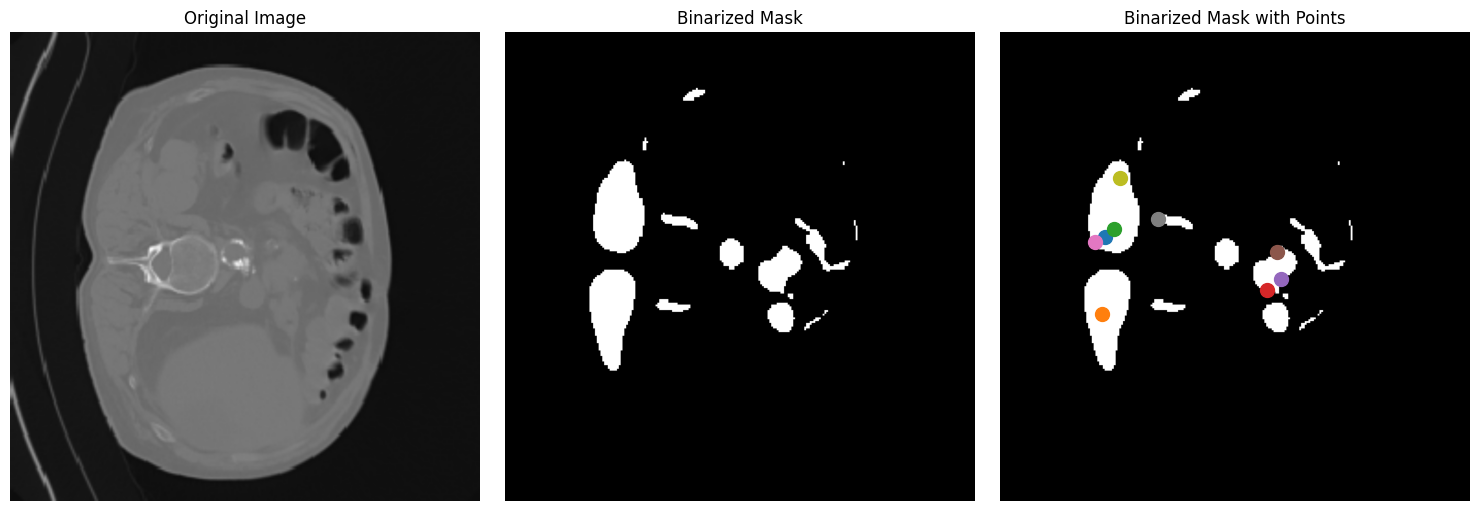

In [38]:
# Visualize the data
Img1, masks1, points1, num_masks = read_batch(train_data, visualize_data=True)

In [51]:
os.chdir("/kaggle/working/segment-anything-2")
from sklearn.model_selection import train_test_split
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

sam2_checkpoint = "/kaggle/working/sam2_hiera_small.pt"  # @param ["sam2_hiera_tiny.pt", "sam2_hiera_small.pt", "sam2_hiera_base_plus.pt", "sam2_hiera_large.pt"]
model_cfg = "sam2_hiera_s.yaml" # @param ["sam2_hiera_t.yaml", "sam2_hiera_s.yaml", "sam2_hiera_b+.yaml", "sam2_hiera_l.yaml"]

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device="cuda")
predictor = SAM2ImagePredictor(sam2_model)

In [52]:
# Train mask decoder.
predictor.model.sam_mask_decoder.train(True)

# Train prompt encoder.
predictor.model.sam_prompt_encoder.train(True)

# Configure optimizer.
optimizer=torch.optim.AdamW(params=predictor.model.parameters(),lr=0.0001,weight_decay=1e-4) #1e-5, weight_decay = 4e-5

# Mix precision.
scaler = torch.cuda.amp.GradScaler()

# No. of steps to train the model.
NO_OF_STEPS = 3000 # @param 

# Fine-tuned model name.
FINE_TUNED_MODEL_NAME = "fine_tuned_sam2"

<ipython-input-52-1400bfbef151>:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [ ]:
os.chdir("/kaggle/working/")

# Initialize scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.2) # 500 , 250, gamma = 0.1
accumulation_steps = 4  # Number of steps to accumulate gradients before updating

for step in range(1, NO_OF_STEPS + 1):
   with torch.cuda.amp.autocast():
       image, mask, input_point, num_masks = read_batch(train_data, visualize_data=False)
       if image is None or mask is None or num_masks == 0:
           continue

       input_label = np.ones((num_masks, 1))
       if not isinstance(input_point, np.ndarray) or not isinstance(input_label, np.ndarray):
           continue

       if input_point.size == 0 or input_label.size == 0:
           continue

       predictor.set_image(image)
       mask_input, unnorm_coords, labels, unnorm_box = predictor._prep_prompts(input_point, input_label, box=None, mask_logits=None, normalize_coords=True)
       if unnorm_coords is None or labels is None or unnorm_coords.shape[0] == 0 or labels.shape[0] == 0:
           continue

       sparse_embeddings, dense_embeddings = predictor.model.sam_prompt_encoder(
           points=(unnorm_coords, labels), boxes=None, masks=None,
       )

       batched_mode = unnorm_coords.shape[0] > 1
       high_res_features = [feat_level[-1].unsqueeze(0) for feat_level in predictor._features["high_res_feats"]]
       low_res_masks, prd_scores, _, _ = predictor.model.sam_mask_decoder(
           image_embeddings=predictor._features["image_embed"][-1].unsqueeze(0),
           image_pe=predictor.model.sam_prompt_encoder.get_dense_pe(),
           sparse_prompt_embeddings=sparse_embeddings,
           dense_prompt_embeddings=dense_embeddings,
           multimask_output=True,
           repeat_image=batched_mode,
           high_res_features=high_res_features,
       )
       prd_masks = predictor._transforms.postprocess_masks(low_res_masks, predictor._orig_hw[-1])

       gt_mask = torch.tensor(mask.astype(np.float32)).cuda()
       prd_mask = torch.sigmoid(prd_masks[:, 0])
       seg_loss = (-gt_mask * torch.log(prd_mask + 0.000001) - (1 - gt_mask) * torch.log((1 - prd_mask) + 0.00001)).mean()

       inter = (gt_mask * (prd_mask > 0.5)).sum(1).sum(1)
       iou = inter / (gt_mask.sum(1).sum(1) + (prd_mask > 0.5).sum(1).sum(1) - inter)
       score_loss = torch.abs(prd_scores[:, 0] - iou).mean()
       loss = seg_loss + score_loss * 0.05

       # Apply gradient accumulation
       loss = loss / accumulation_steps
       scaler.scale(loss).backward()

       # Clip gradients
       torch.nn.utils.clip_grad_norm_(predictor.model.parameters(), max_norm=1.0)

       if step % accumulation_steps == 0:
           scaler.step(optimizer)
           scaler.update()
           predictor.model.zero_grad()

       # Update scheduler
       scheduler.step()

       if step % 500 == 0:
           FINE_TUNED_MODEL = FINE_TUNED_MODEL_NAME + "_" + str(step) + ".torch"
           torch.save(predictor.model.state_dict(), FINE_TUNED_MODEL)

       if step == 1:
           mean_iou = 0

       mean_iou = mean_iou * 0.99 + 0.01 * np.mean(iou.cpu().detach().numpy())

       if step % 100 == 0:
           print("Step " + str(step) + ":\t", "Accuracy (IoU) = ", mean_iou)

<ipython-input-55-a3d7dcdba406>:8: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Step 100:	 Accuracy (IoU) =  0.13165425942031386
Step 200:	 Accuracy (IoU) =  0.18343191108563495


In [42]:
def read_image(image_path, mask_path):  # read and resize image and mask
   img = cv2.imread(image_path)[..., ::-1]  # Convert BGR to RGB
   mask = cv2.imread(mask_path, 0)
   r = np.min([1024 / img.shape[1], 1024 / img.shape[0]])
   img = cv2.resize(img, (int(img.shape[1] * r), int(img.shape[0] * r)))
   mask = cv2.resize(mask, (int(mask.shape[1] * r), int(mask.shape[0] * r)), interpolation=cv2.INTER_NEAREST)
   return img, mask

def get_points(mask, num_points):  # Sample points inside the input mask
   points = []
   coords = np.argwhere(mask > 0)
   for i in range(num_points):
       yx = np.array(coords[np.random.randint(len(coords))])
       points.append([[yx[1], yx[0]]])
   return np.array(points)

<ipython-input-45-1a8d3a068b22>:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  predictor.model.load_state_dict(torch.load(FINE_TUNED_MODEL_WEIGHTS))


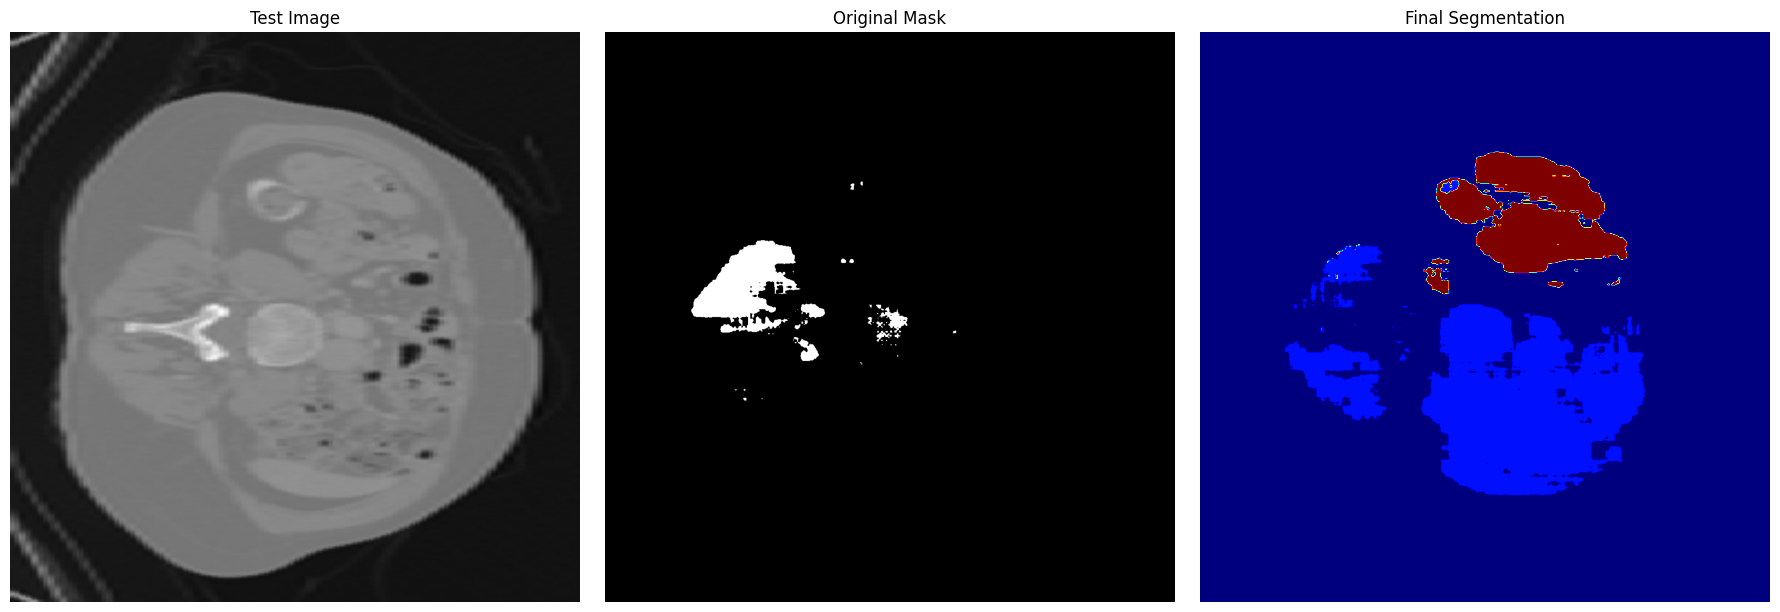

In [45]:
# Randomly select a test image from the test_data
selected_entry = random.choice(test_data)
image_path = selected_entry['image']
mask_path = selected_entry['annotation']

# Load the selected image and mask
image, mask = read_image(image_path, mask_path)

# Generate random points for the input
num_samples = 30  # Number of points per segment to sample
input_points = get_points(mask, num_samples)

# Load the fine-tuned model
FINE_TUNED_MODEL_WEIGHTS = "fine_tuned_sam2_1000.torch"
sam2_model = build_sam2(model_cfg, sam2_checkpoint, device="cuda")

# Build net and load weights
predictor = SAM2ImagePredictor(sam2_model)
predictor.model.load_state_dict(torch.load(FINE_TUNED_MODEL_WEIGHTS))

# Perform inference and predict masks
with torch.no_grad():
   predictor.set_image(image)
   masks, scores, logits = predictor.predict(
       point_coords=input_points,
       point_labels=np.ones([input_points.shape[0], 1])
   )

# Process the predicted masks and sort by scores
np_masks = np.array(masks[:, 0])
np_scores = scores[:, 0]
sorted_masks = np_masks[np.argsort(np_scores)][::-1]

# Initialize segmentation map and occupancy mask
seg_map = np.zeros_like(sorted_masks[0], dtype=np.uint8)
occupancy_mask = np.zeros_like(sorted_masks[0], dtype=bool)

# Combine masks to create the final segmentation map
for i in range(sorted_masks.shape[0]):
   mask = sorted_masks[i]
   if (mask * occupancy_mask).sum() / mask.sum() > 0.15:
       continue

   mask_bool = mask.astype(bool)
   mask_bool[occupancy_mask] = False  # Set overlapping areas to False in the mask
   seg_map[mask_bool] = i + 1  # Use boolean mask to index seg_map
   occupancy_mask[mask_bool] = True  # Update occupancy_mask

# Visualization: Show the original image, mask, and final segmentation side by side
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.title('Test Image')
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Original Mask')
plt.imshow(mask, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Final Segmentation')
plt.imshow(seg_map, cmap='jet')
plt.axis('off')

plt.tight_layout()
plt.show()